# Modeling Agricultural Variables
## Python modules

In [170]:
import warnings
import time
import os
import random

import dask
from dask.distributed import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets

import geopandas as gpd
import pyarrow

from IPython.display import display
from joblib import Parallel, delayed
from matplotlib.axes import Axes
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr
from sklearn.utils import check_random_state, resample


import math
import seaborn as sns

## Read in Data

We first read in the aggregated features and ground-truth data joined in  feature_preprocessing.ipynb 

In [171]:
grouped_features = pd.read_csv("/capstone/mosaiks/repos/modeling/data/model_directory/SEA_averaged_features_simple_impute_modeltrain.csv")

In [172]:
grouped_features

,year,sea_unq,index_left,lon,lat,0_1,0_2,0_3,0_4,0_5,...,prop_mix,log_maize,log_sweetpotatoes,log_groundnuts,log_soybeans,loss_ind,drought_loss_ind,flood_loss_ind,animal_loss_ind,pest_loss_ind
0,2016.0,1,46302.000000,27.807993,-13.659357,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.058626,5.269229,7.640386,6.977090,0.0,0.0,0.0,0.0,0.0
1,2016.0,7,51611.666667,28.634660,-13.772690,0.001141,0.000329,0.000329,0.000329,0.000000,...,0.181102,3.387211,0.689155,7.707512,7.113191,1.0,1.0,0.0,0.0,0.0
2,2016.0,9,44806.714286,27.406446,-12.905428,0.000006,0.000006,0.000006,0.000006,0.000004,...,0.069018,2.703935,8.486127,-1.408767,7.141370,1.0,0.0,0.0,0.0,0.0
3,2016.0,10,44644.411765,27.381719,-12.962298,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.714757,2.525729,3.354421,6.929734,1.0,0.0,0.0,0.0,0.0
4,2016.0,12,47769.000000,28.014660,-12.889357,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.786884,8.509161,2.852125,0.798508,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,2021.0,347,22038.000000,25.204660,-14.879357,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,7.952872,8.294050,8.079163,7.021973,1.0,1.0,0.0,0.0,0.0
535,2021.0,348,19562.000000,24.774660,-14.799357,0.000000,0.000000,0.000018,0.000039,0.000071,...,0.000000,7.642350,8.070906,8.429997,8.006368,1.0,1.0,0.0,0.0,0.0
536,2021.0,355,15659.538462,24.260045,-14.563972,0.000038,0.000038,0.001014,0.000033,0.000028,...,0.000000,7.508878,7.665441,8.211719,5.238174,1.0,0.0,0.0,0.0,0.0
537,2021.0,356,19411.000000,24.752993,-14.764357,0.000158,0.000158,0.000246,0.000040,0.000038,...,0.000000,7.608263,9.042113,8.224773,8.028346,1.0,0.0,0.0,0.0,0.0


In [176]:
features = grouped_features.iloc[:,5:12005]
features.head()

,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10,...,999_3,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,6.157999e-06,0.000207,0.000000,...,1.000000,1.000000,0.274676,1.000000,0.115388,0.002708,0.001319,1.000000,1.000000,1.000000
1,0.001141,0.000329,0.000329,0.000329,0.000000,0.00000,0.000000,1.008277e-03,0.001360,0.002211,...,0.006789,0.006789,1.000000,1.000000,1.000000,0.000517,0.000343,0.000396,0.000327,0.004724
2,0.000006,0.000006,0.000006,0.000006,0.000004,0.00001,0.000014,2.590917e-05,0.000110,0.000109,...,0.005561,0.005561,0.006391,0.004212,0.003235,0.001937,0.001683,0.001970,0.002340,0.005251
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.113844e-07,0.000012,0.000000,...,0.005570,0.005570,0.006739,0.003991,0.002857,0.001979,0.001435,0.001284,0.001814,0.007540
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,9.700000e-06,0.000186,0.000166,...,1.000000,1.000000,1.000000,1.000000,0.002690,0.001603,0.000820,0.001269,0.001692,0.018616


In [177]:
outcomes = grouped_features.iloc[:,12006:]

outcomes["loss_ind"].astype('category')
outcomes["drought_loss_ind"].astype('category')
outcomes['pest_loss_ind'].astype('category')
outcomes['animal_loss_ind'].astype('category')
outcomes['flood_loss_ind'].astype('category')
outcomes.head()

print(outcomes.columns)

Index(['total_area_harv_ha', 'total_area_lost_ha', 'total_harv_kg',
       'yield_kgha', 'frac_area_harv', 'frac_area_loss', 'area_lost_fire',
       'maize', 'groundnuts', 'mixed_beans', 'popcorn', 'sorghum', 'soybeans',
       'sweet_potatoes', 'bunding', 'monocrop', 'mixture', 'frac_loss_drought',
       'frac_loss_flood', 'frac_loss_animal', 'frac_loss_pests',
       'frac_loss_soil', 'frac_loss_fert', 'prop_till_plough',
       'prop_till_ridge', 'prop_notill', 'prop_hand', 'prop_mono', 'prop_mix',
       'log_maize', 'log_sweetpotatoes', 'log_groundnuts', 'log_soybeans',
       'loss_ind', 'drought_loss_ind', 'flood_loss_ind', 'animal_loss_ind',
       'pest_loss_ind'],
      dtype='object')


## Model

We define a model to predict each of our outcome variables on our features for each SEA/year. The `train_and_evaluate_models` function trains and evaluates Ridge Linear Regression models for each target variable specified in the `target_columns` parameter. It handles both categorical and continuous target variables and provides the option to block sample on specific SEAs (Survey Enumeration Areas) by providing the SEA IDs to hold out for the validation set.

The function works as follows:

1. Read the grouped features and outcomes from a CSV file.
2. Define a helper function `block_sampling` to perform block sampling based on the provided SEA IDs.
3. For each target variable in `target_columns`, select the corresponding target variable data.
4. If `block_sea_ids` is provided and not empty, perform block sampling using the `block_sampling` helper function. Otherwise, use `train_test_split` to split the data into training and testing sets.
5. Train a Ridge Linear Regression model using RidgeCV with 5-fold cross-validation and a range of alpha values.
6. If the target variable is categorical, calculate and print the false positive rate and AUC-ROC. If the target variable is continuous, calculate and print the estimated regularization parameter, training R2 performance, validation R2 performance, and Pearson's correlation coefficient.

### Helper Function for Confusion Matrix for Categorical Variables
`calculate_confusion_matrix`:
This function calculates the confusion matrix for binary classification problems based on the given true labels (`y_true`), predicted values (`y_pred`), and a decision boundary (`decision_boundary`). The decision boundary is used to threshold the predicted values to obtain binary predictions.

Inputs:

`y_true`: The true labels of the target variable (a pandas Series or numpy array).

`y_pred`: The predicted values of the target variable (a numpy array).

`decision_boundary`: A float value that serves as the threshold for classifying the predicted values into two classes (0 or 1).


The function performs the following steps:
1. It adjusts the predicted values by setting them to 1 if they are greater than or equal to the decision boundary, and 0 otherwise.
2. It calculates the confusion matrix using the true labels and adjusted predicted values.
3. Depending on the shape of the confusion matrix, it extracts the true negatives (tn), false positives (fp), false negatives (fn), and true positives (tp).
4. If the shape of the confusion matrix is not (1, 1) or (2, 2), it raises an error.

Output: The function returns the values of tn, fp, fn, and tp.

In [178]:
def calculate_confusion_matrix(y_true, y_pred, decision_boundary):
    y_pred_adj = np.where(y_pred >= decision_boundary, 1, 0)
    cm = confusion_matrix(y_true, y_pred_adj)
    if cm.shape == (1, 1):
        if y_true.iloc[0] == 0:
            tn, fp, fn, tp = cm[0, 0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
    elif cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        print("Unexpected confusion matrix:")
        print(cm)
        raise ValueError('Unexpected confusion matrix shape.')
    return tn, fp, fn, tp

In [179]:
def randomly_select_seas(n, grouped_features):
    unique_seas = grouped_features['sea_unq'].unique()
    selected_seas = np.random.choice(unique_seas, n, replace=False)
    return selected_seas

## Cross-Validator Custom Class

This custom cross-validator class, BlockSamplingCV, inherits from the BaseCrossValidator class in scikit-learn. It is designed to perform block sampling for cross-validation, holding out specific groups of observations (in this case, SEA IDs) during each split. This ensures that all observations with the same SEA ID are either in the training set or the test set, but not both.

Here's a detailed explanation of the class:

__init__(self, n_splits=5, n_seas_to_hold_out=10, sea_ids=None, random_state=None):
The constructor takes the following arguments:

n_splits: The number of cross-validation splits (default is 5).
n_seas_to_hold_out: The number of SEAs to hold out in each cross-validation split (default is 10).
sea_ids: A list or array of SEA IDs corresponding to the rows of the dataset (default is None).
random_state: An integer seed or a RandomState instance for reproducible results (default is None).
The constructor initializes the class with these arguments.

_iter_test_indices(self, X=None, y=None, groups=None):
This method generates test indices for each cross-validation split. It takes the following optional arguments:

X: Feature matrix (not used in this method but included for compatibility with scikit-learn).
y: Target variable (not used in this method but included for compatibility with scikit-learn).
groups: Group labels for the samples used to ensure that each group is either entirely in the training or test set (not used in this method but included for compatibility with scikit-learn).
The method performs the following steps:

a. It calculates the total number of samples and extracts the unique SEA IDs from the sea_ids attribute.
b. It initializes a random number generator with the specified random_state.
c. For each split, it randomly selects a set of n_seas_to_hold_out SEA IDs without replacement.
d. It finds the indices of the observations with the selected SEA IDs and yields them as test indices for the current split.

The BlockSamplingCV class is designed to perform cross-validation with block sampling, where groups of observations (in this case, SEA IDs) are held out together during each split. This is useful because it ensures that all observations with the same SEA ID are either in the training set or the test set, but not both. This can help prevent leakage of information between the training and test sets when observations with the same SEA ID are strongly correlated.

In [180]:
# Prepare the arguments as a dictionary
args = {
    'target_columns': ['total_area_harv_ha', 'total_area_lost_ha', 'yield_kgha', 'frac_area_harv', 'frac_area_loss',
                       'maize', 'frac_loss_drought', 'prop_till_plough', 'prop_mono'],
    'test_size': 0.1,
    'categorical_columns':['loss_ind','drought_loss_ind', 'flood_loss_ind','animal_loss_ind','pest_loss_ind'],
    'decision_boundaries': [0.3,0.5,0.7],
    'sea_ids': grouped_features['sea_unq'],
    'validation_size' : 0.1,
    'random_state': 50
}

In [185]:
def train_and_evaluate_models(args):
    target_columns = args['target_columns']
    test_size = args.get('test_size', 0.1)
    categorical_columns = args['categorical_columns']
    decision_boundaries = args['decision_boundaries']
    sea_ids = args['sea_ids']
    validation_size = args.get('validation_size', 0.1)
    random_state = args.get('random_state', False)
    
    
    grouped_features = pd.read_csv("/capstone/mosaiks/repos/modeling/data/model_directory/SEA_averaged_features_simple_impute_modeltrain.csv")

    features = grouped_features.iloc[:, 5:12005]
    outcomes = grouped_features.iloc[:, 12006:]
    
    
    # Initialize an empty DataFrame to store the metrics
    metrics_df = pd.DataFrame(columns=['target_column', 'train_score', 'val_score', 'pearson_coeff'])
    # Initialize an empty DataFrame to store groundtruth
    models = {}
    X_trains = {}
    X_tests = {}
    y_trains = pd.DataFrame()
    y_tests = pd.DataFrame()
    
    
    print(f"\nRunning model with the following parameters:")
    print(f"Target columns: {target_columns}")
    print(f"Test size: {test_size}", f"Validation size: {validation_size}")
    print(f"Random State: {random_state}")

    for target_column in target_columns:
        
            X_train, X_test, y_train, y_test = train_test_split(features, outcomes[target_column], test_size=test_size, random_state = random_state)
            # Split the training data again to create a validation set
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state = random_state)
            
            X_trains[target_column] = X_train
            X_tests[target_column] = X_test
            y_trains[target_column] = y_train
            y_tests[target_column] = y_test

            cv = 5
            ridge_cv = RidgeCV(cv=cv, alphas=np.logspace(-8, 8, base=10, num=75))
            ridge_cv.fit(X_train, y_train)
            
            models[target_column] = ridge_cv
            
            # Make predictions on the training and validation data
            y_val_pred = ridge_cv.predict(X_val)
            y_train_pred = ridge_cv.predict(X_train)
    
            if target_column in categorical_columns:
                for decision_boundary in decision_boundaries:
                    # Calculate confusion matrix
                    tn, fp, fn, tp = calculate_confusion_matrix(y_val, y_val_pred, decision_boundary)

                # Calculate the false positive rate
                    false_positive_rate = fp / (fp + tn)

                # Calculate AUC-ROC
                    auc_roc = roc_auc_score(y_val, y_val_pred)

                    print(f"Target variable: {target_column} (Categorical)")
                    print(f"Decision boundary: {decision_boundary}")
                    print(f"False positive rate: {false_positive_rate:0.2f}")
                    print(f"AUC-ROC: {auc_roc:0.2f}")
                    print()
            else:
                # Calculate Pearson's correlation coefficient
                pearson_coeff, _ = pearsonr(y_val, y_val_pred)

                # Calculate training R squared
                train_r_squared = ridge_cv.score(X_train, y_train)

                # Calculate validation R squared
                val_r_squared = ridge_cv.score(X_val, y_val)
                
                metrics_df = metrics_df.append({
                'target_column': target_column,
                'train_score': train_r_squared,
                'val_score': val_r_squared,
                'pearson_coeff': pearson_coeff}, ignore_index=True)
                    
                print()
                print(f"Target variable: {target_column}")
                print(f"Estimated regularization parameter: {ridge_cv.alpha_}")
                print(f"Training R2 performance: {train_r_squared:0.2f}")
                print(f"Validation R2 performance: {val_r_squared:0.2f}")
                print(f"Pearson's correlation coefficient: {pearson_coeff:0.2f}")
                print()
                

    return X_trains, X_tests, y_trains, y_tests, metrics_df, models 

In [186]:
X_trains, X_tests, y_trains, y_tests, metrics_df, models  = train_and_evaluate_models(args)


Running model with the following parameters:
Target columns: ['total_area_harv_ha', 'total_area_lost_ha', 'yield_kgha', 'frac_area_harv', 'frac_area_loss', 'maize', 'frac_loss_drought', 'prop_till_plough', 'prop_mono']
Test size: 0.1 Validation size: 0.1
Random State: 50


/tmp/ipykernel_1377110/4270161684.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({



Target variable: total_area_harv_ha
Estimated regularization parameter: 4.45295850994266
Training R2 performance: 0.71
Validation R2 performance: 0.46
Pearson's correlation coefficient: 0.69



/tmp/ipykernel_1377110/4270161684.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({



Target variable: total_area_lost_ha
Estimated regularization parameter: 2.706652070033247
Training R2 performance: 0.75
Validation R2 performance: 0.50
Pearson's correlation coefficient: 0.72



/tmp/ipykernel_1377110/4270161684.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({



Target variable: yield_kgha
Estimated regularization parameter: 1.6451905877536674
Training R2 performance: 0.74
Validation R2 performance: 0.62
Pearson's correlation coefficient: 0.80



/tmp/ipykernel_1377110/4270161684.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({



Target variable: frac_area_harv
Estimated regularization parameter: 4.45295850994266
Training R2 performance: 0.64
Validation R2 performance: 0.46
Pearson's correlation coefficient: 0.71



/tmp/ipykernel_1377110/4270161684.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({



Target variable: frac_area_loss
Estimated regularization parameter: 4.45295850994266
Training R2 performance: 0.64
Validation R2 performance: 0.46
Pearson's correlation coefficient: 0.71



/tmp/ipykernel_1377110/4270161684.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({



Target variable: maize
Estimated regularization parameter: 1.0
Training R2 performance: 0.77
Validation R2 performance: 0.61
Pearson's correlation coefficient: 0.79



/tmp/ipykernel_1377110/4270161684.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({



Target variable: frac_loss_drought
Estimated regularization parameter: 238.98925662310526
Training R2 performance: 0.42
Validation R2 performance: 0.38
Pearson's correlation coefficient: 0.62



/tmp/ipykernel_1377110/4270161684.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({



Target variable: prop_till_plough
Estimated regularization parameter: 7.3259654282152304
Training R2 performance: 0.78
Validation R2 performance: 0.71
Pearson's correlation coefficient: 0.85


Target variable: prop_mono
Estimated regularization parameter: 0.369460120519931
Training R2 performance: 0.90
Validation R2 performance: 0.56
Pearson's correlation coefficient: 0.76



/tmp/ipykernel_1377110/4270161684.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


### Train Set

In [188]:
# Initialize empty dictionaries for storing the predicted values and R2 scores
y_pred_train = pd.DataFrame()
r2_train = pd.DataFrame()

# Iterate over the keys in models dictionary
for target_column in models.keys():
    # Get the corresponding trained model for the target column
    model = models[target_column]
    
    # Get the training data for the target column
    X_train_column = X_trains[target_column]
    y_train_column = y_trains[target_column]
    
    # Make predictions for the target column
    y_pred_train_column = np.maximum(model.predict(X_train_column), 0)
    
    # Compute the R2 score for the target column
    r2_train_column = r2_score(y_train_column, y_pred_train_column)
    
    # Store the predicted values and R2 score in their respective dictionaries
    y_pred_train[target_column] = y_pred_train_column
    r2_train[target_column] = [r2_train_column]

In [201]:
y_pred_train

,total_area_harv_ha,total_area_lost_ha,yield_kgha,frac_area_harv,frac_area_loss,maize,frac_loss_drought,prop_till_plough,prop_mono
0,935.813979,1289.657304,156.162266,0.443569,0.556431,218.023574,0.063168,0.294333,0.890543
1,1233.538655,2082.036541,38.363936,0.372473,0.627527,0.000000,0.000000,0.300490,0.933498
2,621.752010,500.072322,1373.119866,0.676181,0.323819,1628.506074,0.146015,0.903735,0.764655
3,616.200430,900.484352,2307.667465,0.758817,0.241183,2230.649639,0.075028,0.525004,0.787863
4,0.000000,0.000000,2429.729313,1.012649,0.000000,2417.996095,0.000000,0.184509,0.849401
...,...,...,...,...,...,...,...,...,...
431,201.501086,294.759881,557.519967,0.721507,0.278493,420.252478,0.004663,0.180570,0.168821
432,354.944378,248.472364,2367.528600,0.813160,0.186840,2571.834044,0.047977,0.191094,0.789363
433,1005.255472,141.070388,27.462561,0.841604,0.158396,81.991781,0.185424,0.911116,0.000000
434,290.158395,328.793389,80.749898,0.627363,0.372637,122.553781,0.156982,0.353078,0.098579


### Visualize Performance of Train Set 

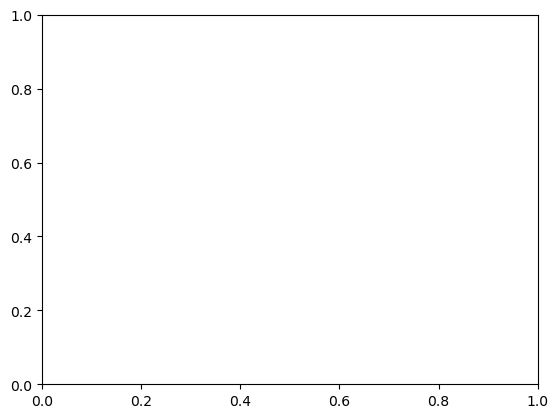

In [204]:
# Create a list of variable names from the dataframes
variable_names = list(y_pred_train.columns)

# create a container widget to hold the dropdown and the plot
container = widgets.VBox(children=[variable_dropdown])

# Create the dropdown widget
variable_dropdown = widgets.Dropdown(options=variable_names, description='Variable:')

# Create an output widget to display the plot
plot_output = widgets.Output()

# Define a function to update the plot based on the selected variable
def update_plot_train(variable):
    with plot_output:
        clear_output(wait=True)
        # Create the scatterplot
        fig, ax = plt.subplots()
        ax.scatter(y_pred_train[variable], y_trains[variable])
        ax.axline([0, 0], [1, 1], c="k")

        # Extract the R2 value from the r2_train dataframe
        r2_value = r2_train[variable]
        r2_value = round(r2_value, 2)

        # Set the title with the R2 value and selected variable
        plt.title(f"Model applied to train data n = {len(y_trains)}, R$^2$ = {r2_value}",
          fontsize=12, y=1)

        # Set x and y axis labels
        ax.set_xlabel("Predicted", fontsize=15)
        ax.set_ylabel("Ground Truth", fontsize=15)

        # Display the plot
        plt.show()

# call the update_plot function with the initial value of the dropdown
plot_output = widgets.Output()
update_plot_train(variable_dropdown.value)
container.children = [variable_dropdown, plot_output]

# set up the interaction between the dropdown and the plot
def dropdown_eventhandler(change):
    variable = change.new
    update_plot(variable)

variable_dropdown.observe(dropdown_eventhandler, names='value')

# display the dropdown and the plot
display(container)

### Test Set 

In [193]:
# Initialize empty dictionaries for storing the predicted values and R2 scores
y_pred_test = pd.DataFrame()
r2_test = pd.DataFrame()

# Iterate over the keys in models dictionary
for target_column in models.keys():
    # Get the corresponding trained model for the target column
    model = models[target_column]
    
    # Get the training data for the target column
    X_test_column = X_tests[target_column]
    y_test_column = y_tests[target_column]
    
    # Make predictions for the target column
    y_pred_test_column = np.maximum(model.predict(X_test_column), 0)
    
    # Compute the R2 score for the target column
    r2_test_column = r2_score(y_test_column, y_pred_test_column)
    
    # Store the predicted values and R2 score in their respective dictionaries
    y_pred_test[target_column] = y_pred_test_column
    r2_test[target_column] = [r2_test_column]

In [194]:
r2_test

,total_area_harv_ha,total_area_lost_ha,yield_kgha,frac_area_harv,frac_area_loss,maize,frac_loss_drought,prop_till_plough,prop_mono
0,0.633185,0.588055,0.579056,0.19504,0.19617,0.597363,0.32201,0.849608,0.677063


### Visualize Performance of Test Set 

In [198]:
# Create a list of variable names from the dataframes
variable_names = list(y_pred_test.columns)

# create a container widget to hold the dropdown and the plot
container = widgets.VBox(children=[variable_dropdown])

# Define a function to update the plot based on the selected variable
def update_plot_test(variable):
    with plot_output:
        clear_output(wait=True)
        # Create the scatterplot
        fig, ax = plt.subplots()
        ax.scatter(y_pred_test[variable], y_tests[variable])
        ax.axline([0, 0], [1, 1], c="k")

        # Extract the R2 value from the r2_train dataframe
        r2_value = r2_test[variable]
        r2_value = round(r2_value, 2)

        # Set the title with the R2 value and selected variable
        plt.title(f"Model applied to test data n = {len(y_tests)}, R$^2$ = {r2_value}",
          fontsize=12, y=1)

        # Set x and y axis labels
        ax.set_xlabel("Predicted", fontsize=15)
        ax.set_ylabel("Ground Truth", fontsize=15)

        # Display the plot
        plt.show()

# call the update_plot function with the initial value of the dropdown
plot_output = widgets.Output()
update_plot_test(variable_dropdown.value)
container.children = [variable_dropdown, plot_output]

# set up the interaction between the dropdown and the plot
def dropdown_eventhandler(change):
    variable = change.new
    update_plot(variable)

variable_dropdown.observe(dropdown_eventhandler, names='value')

# display the dropdown and the plot
display(container)

### Apply Model to Ungrouped SEA Features

In [148]:
features_sea_ungrouped = pd.read_feather("/capstone/mosaiks/repos/modeling/data/model_directory/SEA_ungroup_features_simple_impute.feather")

In [153]:
features_sea = features_sea_ungrouped.iloc[:, 2:12002]

,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10,...,999_3,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12
0,0.001143,0.000751,0.000000,0.000346,0.000000,0.000000,0.000000,0.000000,0.000000,0.001020,...,0.034016,0.071989,0.532948,0.469076,0.007786,0.006779,0.004811,0.001675,0.029891,0.033437
1,0.001143,0.000000,0.000776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000308,...,0.043530,0.494736,0.474246,0.417571,0.135569,0.003355,0.004876,0.003185,0.187867,0.156783
2,0.001143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000234,0.000039,...,0.021665,0.324015,0.490193,0.392582,0.325692,0.004587,0.002309,0.002191,0.002333,0.033437
3,0.001143,0.000751,0.000776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000657,0.000894,...,0.043530,0.718919,0.645601,0.673485,0.631725,0.004959,0.001359,0.001627,0.052683,0.033437
4,0.000000,0.000751,0.000776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.001360,...,0.043530,1.000000,0.679722,1.000000,0.324600,0.006641,0.003481,0.003071,0.004119,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72278,0.001143,0.003581,0.003867,0.001019,0.001521,0.000000,0.002637,0.003194,0.004948,0.005988,...,0.008950,0.013373,0.009622,0.008655,0.003418,0.001569,0.000234,0.000054,0.000039,0.000276
72279,0.000000,0.000000,0.000000,0.000000,0.000000,0.002137,0.003117,0.004004,0.004732,0.000000,...,0.013883,0.014116,0.009862,0.002694,0.000432,0.000132,0.000086,0.000063,0.000060,0.033437
72280,0.002399,0.000751,0.000000,0.000000,0.001860,0.002130,0.002149,0.000000,0.004094,0.006669,...,0.012160,0.011552,0.013037,0.007480,0.002309,0.000083,0.000194,0.000100,0.000016,0.004205
72281,0.003386,0.000000,0.000000,0.000000,0.000923,0.002777,0.003057,0.004031,0.000000,0.000000,...,0.005391,0.004631,0.007071,0.001832,0.001039,0.000223,0.000081,0.000324,0.001030,0.004801


In [155]:
# Initialize empty dictionaries for storing the predicted values and R2 scores
y_pred_sea = pd.DataFrame()

# Iterate over the keys in models dictionary
for target_column in models.keys():
    # Get the corresponding trained model for the target column
    model = models[target_column]
    
    # Make predictions for the target column
    y_pred_sea_column = np.maximum(model.predict(features_sea), 0)
    
    # Store the predicted values and R2 score in their respective dictionaries
    y_pred_sea[target_column] = y_pred_sea_column

In [162]:
# Select the columns from features
selected_columns_sea = features_ungrouped[['lat', 'lon', 'year']]

# Concatenate selected_columns with y_preds
sea_preds = pd.concat([selected_columns_sea, y_pred_sea], axis=1)

# Display the combined dataframe
sea_preds

In [ ]:
sea_preds.to_feather("/capstone/mosaiks/repos/modeling/data/predictions/SEA_predictions_ungrouped.feather")

## Apply Model to Zambia 10% Data


In [163]:
zambia = pd.read_feather("/capstone/mosaiks/repos/modeling/data/model_directory/zambia_10percent_features_simple_impute_modelpredict.feather")

In [165]:
zambia_features = zambia.iloc[:,2:12002]
zambia_features.head()

,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10,...,999_3,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12
0,0.002994,0.003749,0.002417,0.001449,0.001208,0.002577,0.002151,0.003231,0.004019,0.001838,...,0.000653,0.001410,0.001619,0.000461,0.000611,0.000226,0.000138,0.000562,0.000503,0.000406
1,0.002030,0.000743,0.000000,0.000000,0.000000,0.000007,0.000035,0.000189,0.000664,0.002471,...,0.012280,0.009524,0.006202,0.004043,0.003652,0.002408,0.001475,0.000435,0.000302,0.005276
2,0.001111,0.003541,0.003555,0.001752,0.001398,0.001469,0.002361,0.002198,0.003063,0.005263,...,0.001252,0.004579,0.003310,0.002417,0.001392,0.001687,0.000812,0.000241,0.000365,0.000645
3,0.001111,0.000743,0.000706,0.000395,0.000185,0.000202,0.000298,0.000640,0.001207,0.004661,...,0.055707,0.075393,0.056347,0.056281,0.036438,0.004060,0.008108,0.000633,0.000496,0.000598
4,0.001111,0.000743,0.000706,0.000395,0.000185,0.000202,0.000298,0.000640,0.004295,0.001444,...,0.055707,0.075393,0.056347,0.056281,0.036438,0.004060,0.000187,0.002911,0.004108,0.035491


In [166]:
# Initialize empty dictionaries for storing the predicted values and R2 scores
y_pred_zambia = pd.DataFrame()

# Iterate over the keys in models dictionary
for target_column in models.keys():
    # Get the corresponding trained model for the target column
    model = models[target_column]
    
    # Make predictions for the target column
    y_pred_zambia_column = np.maximum(model.predict(zambia_features), 0)
    
    # Store the predicted values and R2 score in their respective dictionaries
    y_pred_zambia[target_column] = y_pred_zambia_column

In [167]:
y_pred_zambia.head()

,total_area_harv_ha,total_area_lost_ha,yield_kgha,frac_area_harv,frac_area_loss,maize,frac_loss_drought,prop_till_plough,prop_mono
0,0.000000,0.000000,1735.397458,0.813706,0.186294,1722.112146,0.000000,0.000000,1.073670
1,447.061644,256.229862,2331.179534,0.935772,0.064228,2405.568184,0.046058,0.550284,0.400076
2,1206.135845,2076.177727,1970.026901,0.587526,0.412474,1764.996532,0.053027,0.100866,0.471011
3,670.181614,898.956082,1155.632228,0.622778,0.377222,1093.192949,0.096518,0.632547,0.714045
4,588.095553,878.123450,1066.901627,0.603163,0.396837,1051.265307,0.052540,0.513613,0.712723


In [168]:
# Select the columns from features
selected_columns_zambia = zambia[['lat', 'lon', 'year']]

# Concatenate selected_columns with y_preds
zambia_preds = pd.concat([selected_columns_zambia, y_pred_zambia], axis=1)

# Display the combined dataframe
zambia_preds

,lat,lon,year,total_area_harv_ha,total_area_lost_ha,yield_kgha,frac_area_harv,frac_area_loss,maize,frac_loss_drought,prop_till_plough,prop_mono
0,-15.053257,22.730588,2019.0,0.000000,0.000000,1735.397458,0.813706,0.186294,1722.112146,0.000000,0.000000,1.073670
1,-15.053257,22.730588,2018.0,447.061644,256.229862,2331.179534,0.935772,0.064228,2405.568184,0.046058,0.550284,0.400076
2,-15.053257,22.730588,2022.0,1206.135845,2076.177727,1970.026901,0.587526,0.412474,1764.996532,0.053027,0.100866,0.471011
3,-15.053257,22.730588,2023.0,670.181614,898.956082,1155.632228,0.622778,0.377222,1093.192949,0.096518,0.632547,0.714045
4,-15.053257,22.730588,2015.0,588.095553,878.123450,1066.901627,0.603163,0.396837,1051.265307,0.052540,0.513613,0.712723
...,...,...,...,...,...,...,...,...,...,...,...,...
680651,-17.473257,26.080588,2016.0,0.000000,0.000000,596.193086,1.145336,0.000000,352.100772,0.165099,1.075864,0.000000
680652,-17.473257,26.080588,2015.0,102.839855,0.000000,3497.057246,0.813705,0.186295,4081.543865,0.027710,0.556807,1.361831
680653,-17.473257,26.080588,2015.0,102.839855,0.000000,3497.057246,0.813705,0.186295,4081.543865,0.027710,0.556807,1.361831
680654,-17.473257,26.080588,2018.0,768.755230,983.689961,987.401820,0.665632,0.334368,1079.121809,0.144083,0.831311,0.631516


In [169]:
zambia_preds.to_feather("/capstone/mosaiks/repos/modeling/data/predictions/zambia_10perc_predictions.feather")

### Congratulations on completing this analysis!